# Imports

In [1]:
import numpy as np
from scipy.signal import butter, filtfilt, argrelextrema
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Read data

In [3]:
df_correct = pd.read_pickle("../data/out/imu_correct.pkl")
df_incorrect = pd.read_pickle("../data/out/imu_incorrect.pkl")

# Label sets and reps

## Label sets 

In [9]:
# --------------------------------------------------------------
# Label sets of 10.
# This was a manual step, cut indices were determined by visual inspection.
# --------------------------------------------------------------

# Define the start and end indices for each participant's sets
all_start_end_c = {
    'Participant_A': [(260, 2000), (2400, 4050), (4390, 6060)],
    'Participant_B': [(6490, 8350), (8450, 10455), (10835, 12600)],
    'Participant_C': [(12900, 14350), (14470, 15890), (16030, 17420)],
    'Participant_D': [(17850,19480), (19570, 21200), (21300, 22910)],
    'Participant_E': [(23300, 25000), (25100,26660), (26760, 28350)]
}

all_start_end_i = {
    'Participant_A': [(150, 1450), (1600, 2920), (3150, 4470)],
    'Participant_B': [(4980, 6125), (6165, 7195), (7330, 8415)],
    'Participant_C': [(8720, 9900), (10070, 11360), (11500, 12900)],
    'Participant_D': [(13500, 14400), (14500, 15400), (15520, 16350)],
    'Participant_E': [(16940, 17870), (17950, 18780), (18860, 19880)]
}


def label_sets(df, start_end_all):
    df = df.copy()
    df['Set'] = 0
    for participant, start_end in start_end_all.items():
        for idx, (start, end) in enumerate(start_end, start=1):
            df.loc[df.index[start:end + 1], "Set"] = idx
    df = df[df['Set'] != 0]
    return df


df_correct_labeled = label_sets(df_correct, all_start_end_c)
df_correct_labeled = df_correct_labeled.reset_index(drop=True)

df_incorrect_labeled = label_sets(df_incorrect, all_start_end_i)
df_incorrect_labeled = df_incorrect_labeled.reset_index(drop=True)

## Label reps

In [10]:
# --------------------------------------------------------------
# Label individual repetitions.
# This is an automatic step.
# --------------------------------------------------------------

def low_pass_filter(data, cutoff_freq, fs, order=1):
    nyq = 0.5 * fs
    normal_cutoff = cutoff_freq / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data.values)
    return pd.Series(y, index=data.index)


def label_repetitions(df, column_name='Left Hand z position', buffer=50):
    df['Repetition'] = 0
    unique_participants = df['Participant'].unique()
    unique_sets = df['Set'].unique()

    for participant in unique_participants:
        for set_num in unique_sets:
            data = df[(df['Participant'] == participant) & (df['Set'] == set_num)]
            if data.empty:
                continue

            filtered = low_pass_filter(data[column_name], cutoff_freq=3, fs=60)
            minima_indices = argrelextrema(filtered.values, np.less)[0]
            index_array = filtered.index.values
            minima_indices = index_array[minima_indices]

            if not np.any(minima_indices < buffer):
                minima_indices = np.insert(minima_indices, 0, index_array[0])
            if not np.any(minima_indices > index_array[-1] - buffer):
                minima_indices = np.append(minima_indices, index_array[-1])

            filtered_minima_z = []
            min_distance = 60  # minimum acceptable distance between consecutive minima
            for i in range(len(minima_indices)):
                if i == 0 or (minima_indices[i] - minima_indices[i - 1]) >= min_distance:
                    filtered_minima_z.append(minima_indices[i])

            # Label repetitions 
            for rep_id, (start, end) in enumerate(zip(filtered_minima_z[:-1], filtered_minima_z[1:]), start=1):
                print(participant, rep_id, end-start)
                df.loc[(df.index >= start) & (df.index < end) & (df['Participant'] == participant) & (
                        df['Set'] == set_num), 'Repetition'] = rep_id
    df = df[df['Repetition'] != 0]
    return df

reps = label_repetitions(df_correct_labeled)
reps_incorrect = label_repetitions(df_incorrect_labeled)

reps.to_pickle("data/out/df_correct_reps.pkl")
reps_incorrect.to_pickle("data/out/df_incorrect_reps.pkl")

Participant_A 1 200
Participant_A 2 175
Participant_A 3 174
Participant_A 4 162
Participant_A 5 168
Participant_A 6 169
Participant_A 7 163
Participant_A 8 169
Participant_A 9 177
Participant_A 10 166
Participant_A 1 180
Participant_A 2 161
Participant_A 3 175
Participant_A 4 172
Participant_A 5 175
Participant_A 6 168
Participant_A 7 156
Participant_A 8 146
Participant_A 9 165
Participant_A 10 149
Participant_A 1 156
Participant_A 2 173
Participant_A 3 165
Participant_A 4 159
Participant_A 5 177
Participant_A 6 165
Participant_A 7 163
Participant_A 8 165
Participant_A 9 184
Participant_A 10 163
Participant_B 1 183
Participant_B 2 207
Participant_B 3 207
Participant_B 4 208
Participant_B 5 180
Participant_B 6 168
Participant_B 7 184
Participant_B 8 173
Participant_B 9 177
Participant_B 10 162
Participant_B 1 207
Participant_B 2 200
Participant_B 3 213
Participant_B 4 211
Participant_B 5 220
Participant_B 6 209
Participant_B 7 213
Participant_B 8 172
Participant_B 9 195
Participant_B 10

['Participant_A' 'Participant_B' 'Participant_C' 'Participant_D'
 'Participant_E']


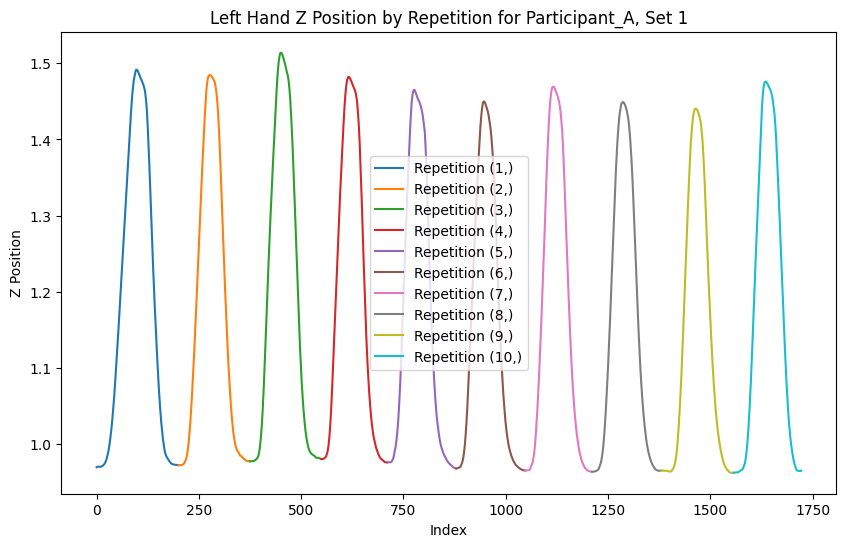

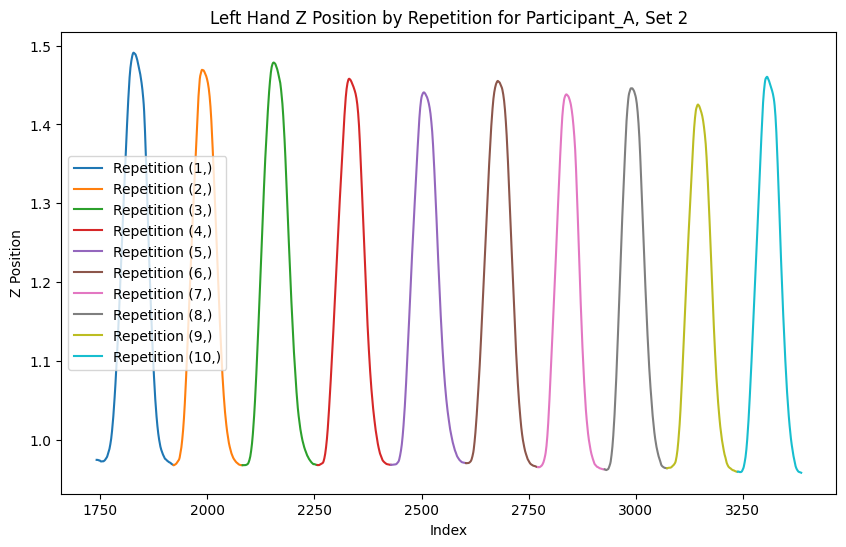

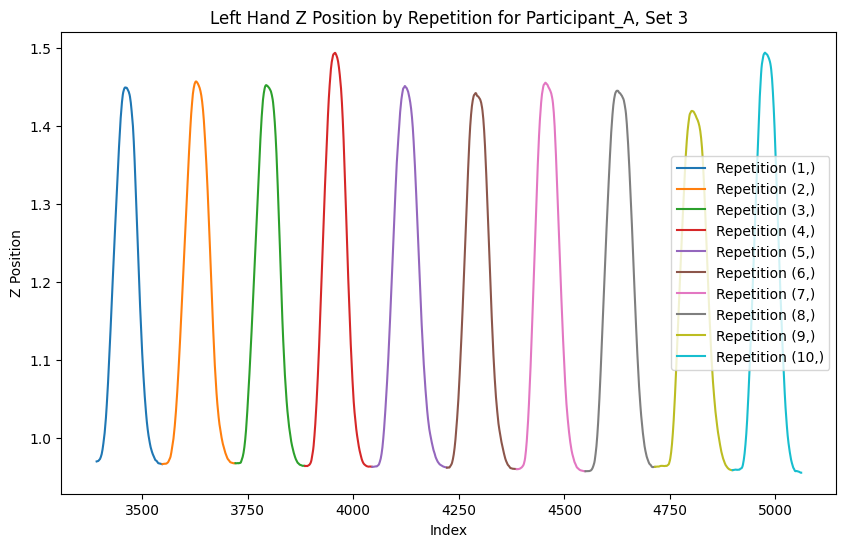

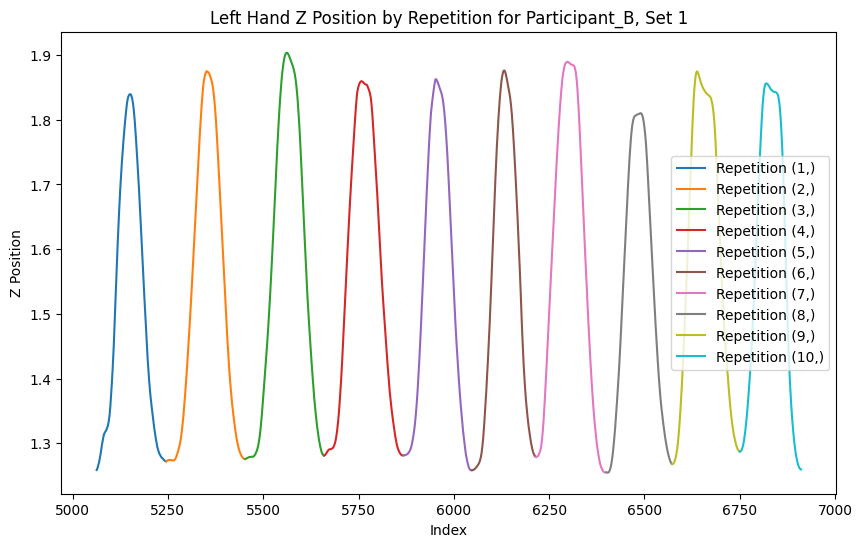

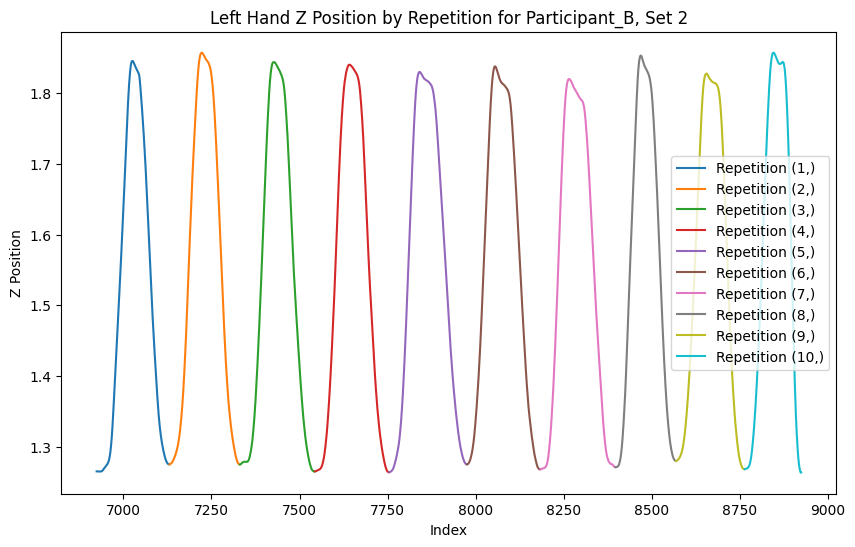

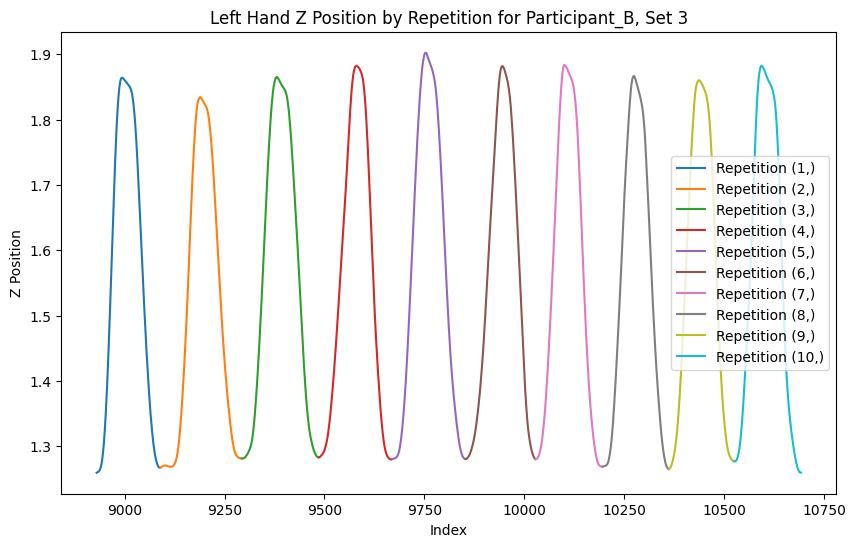

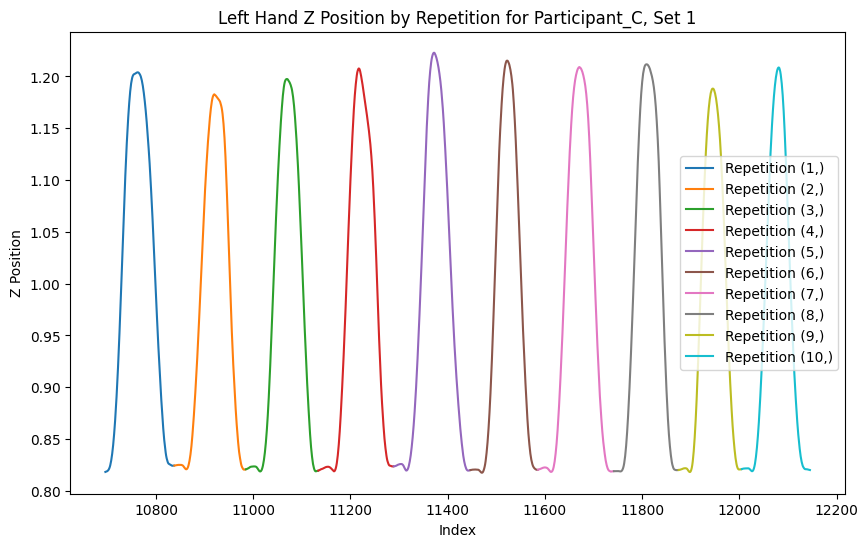

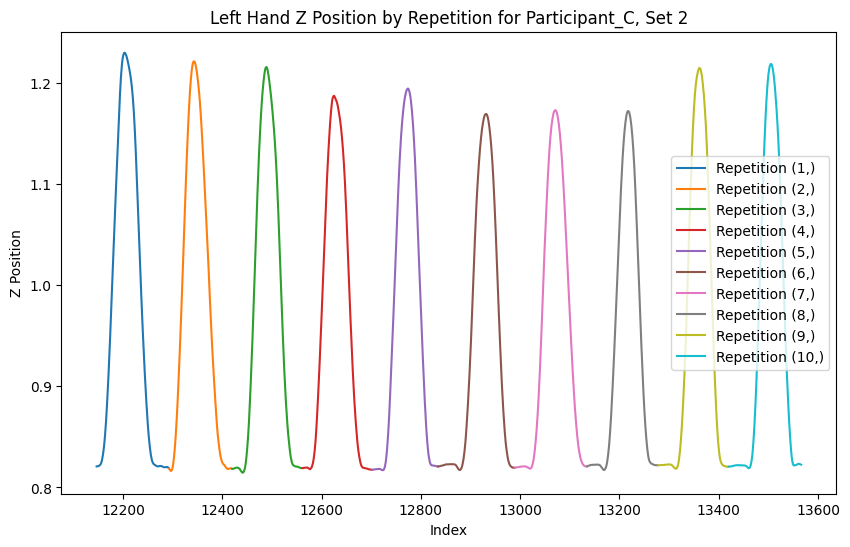

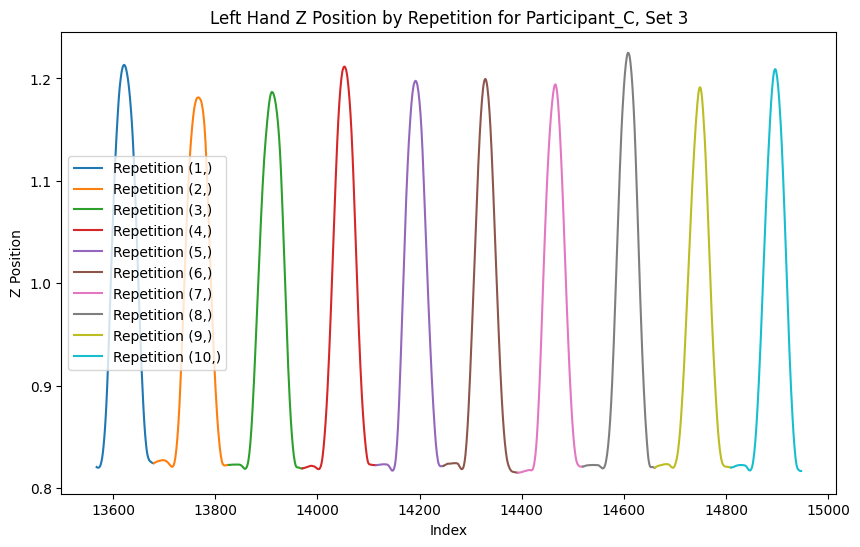

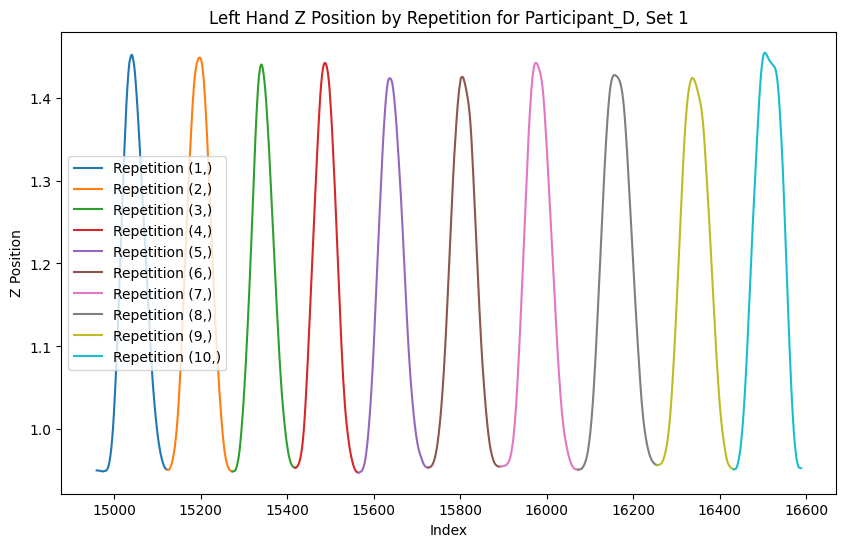

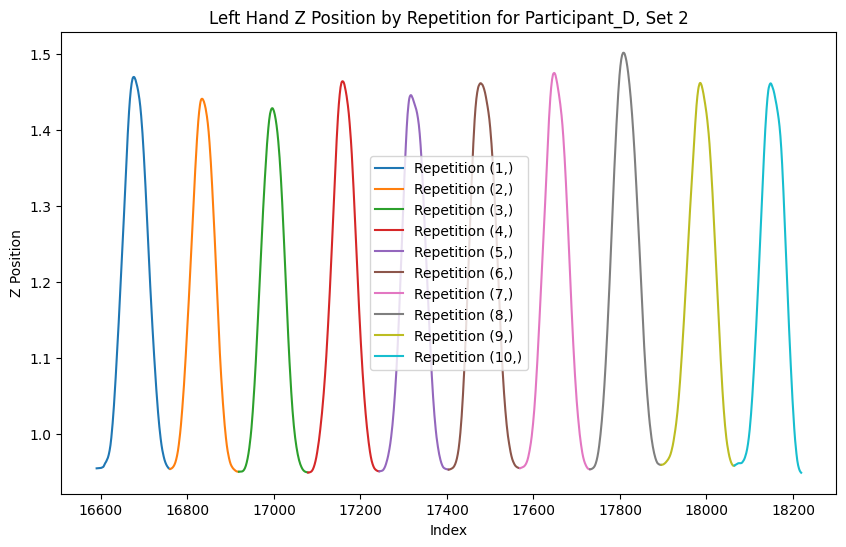

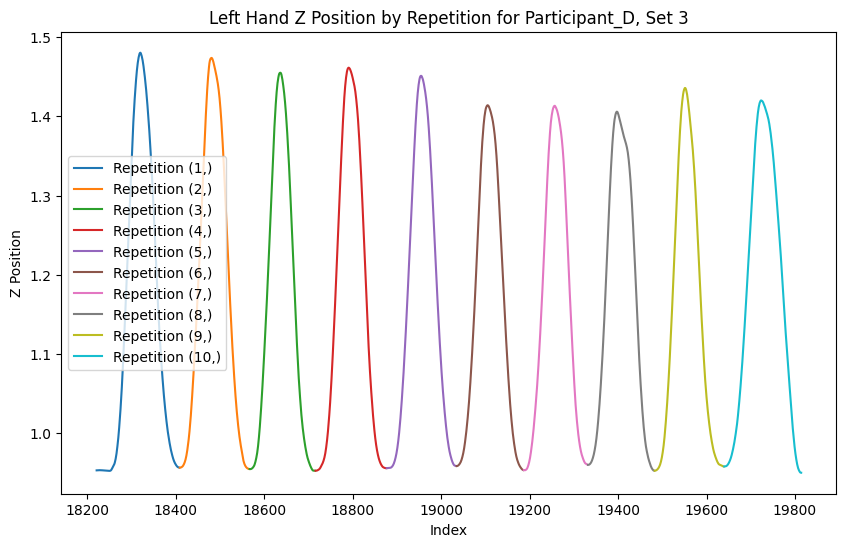

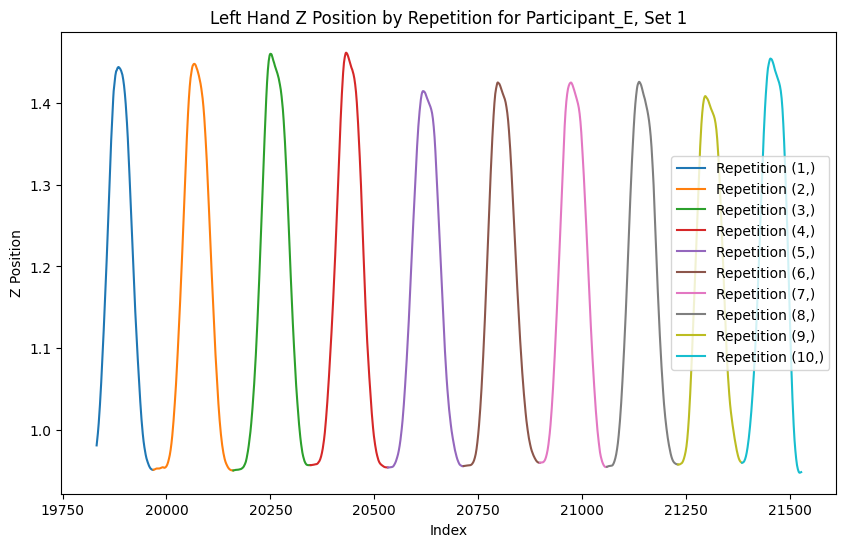

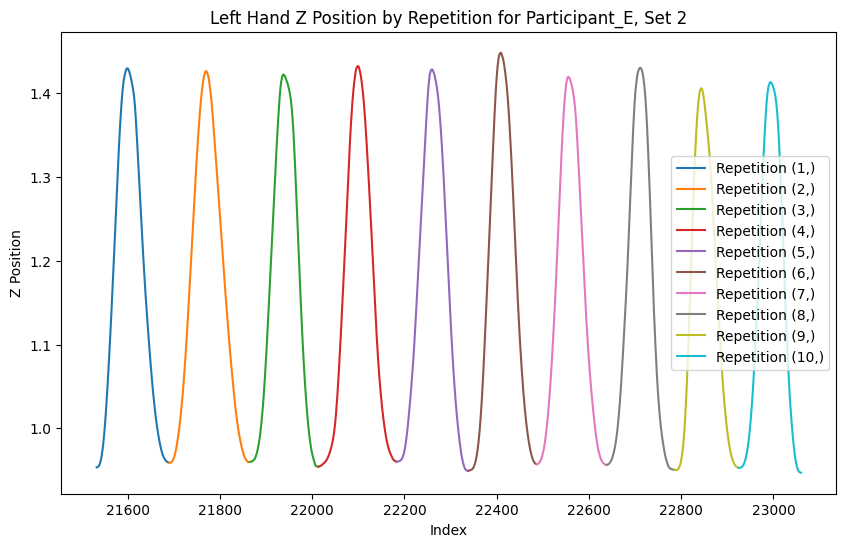

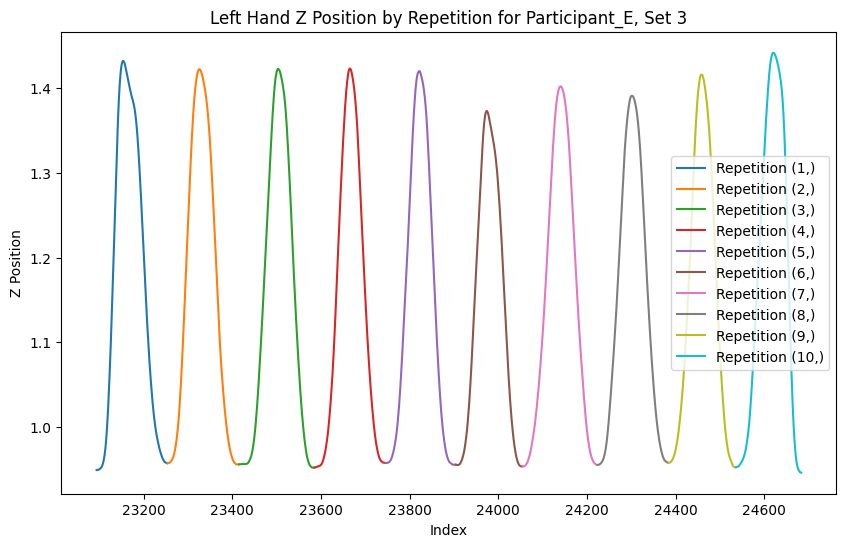

['Participant_A' 'Participant_B' 'Participant_C' 'Participant_D'
 'Participant_E']


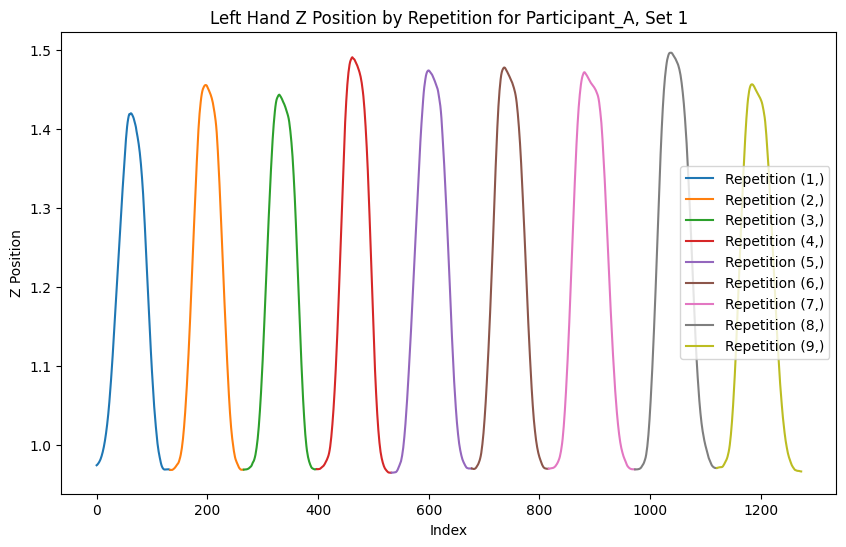

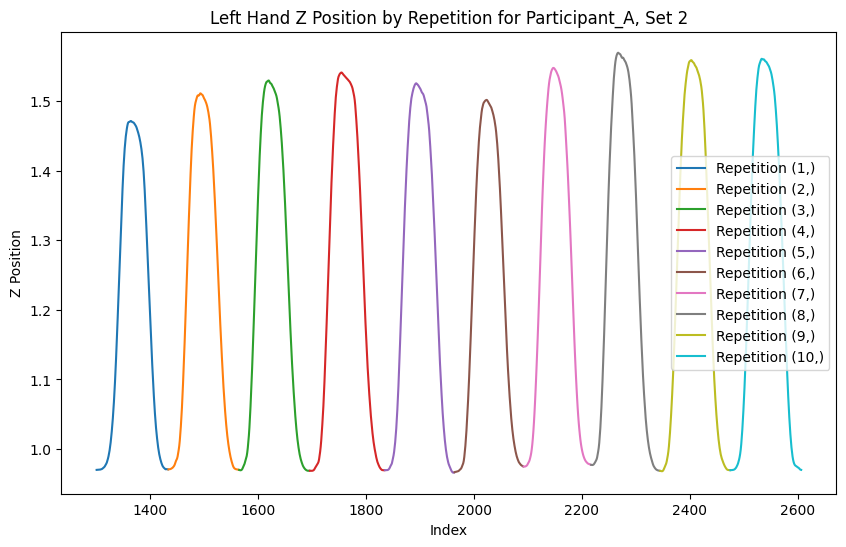

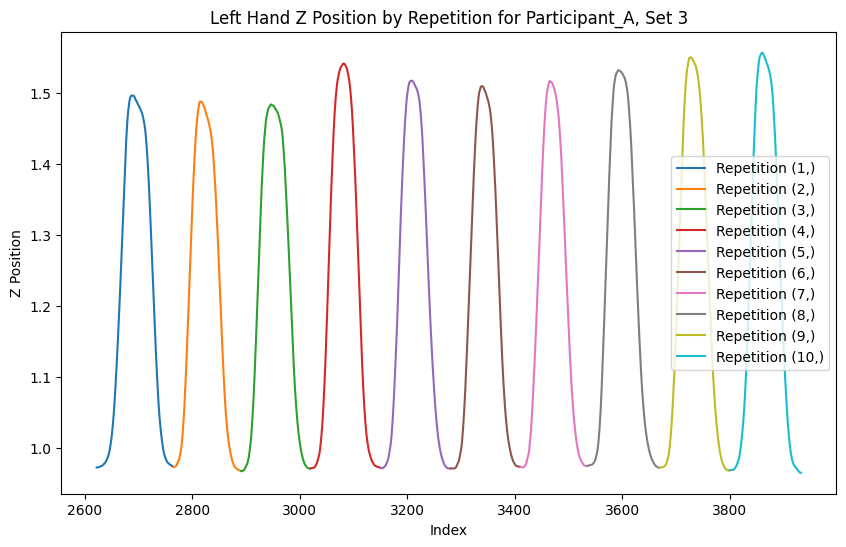

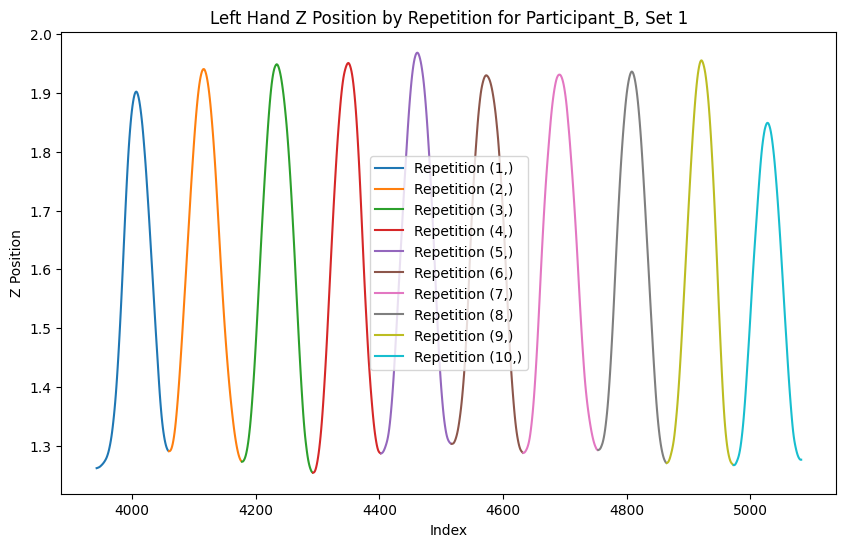

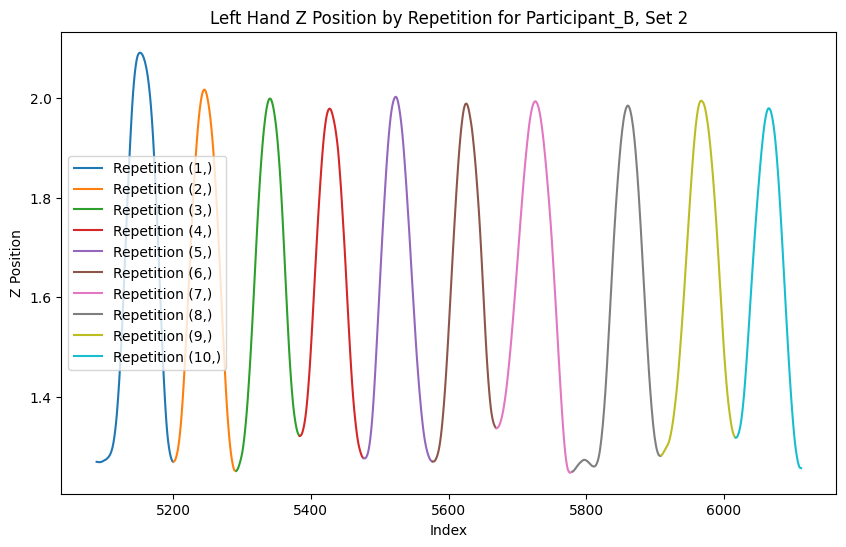

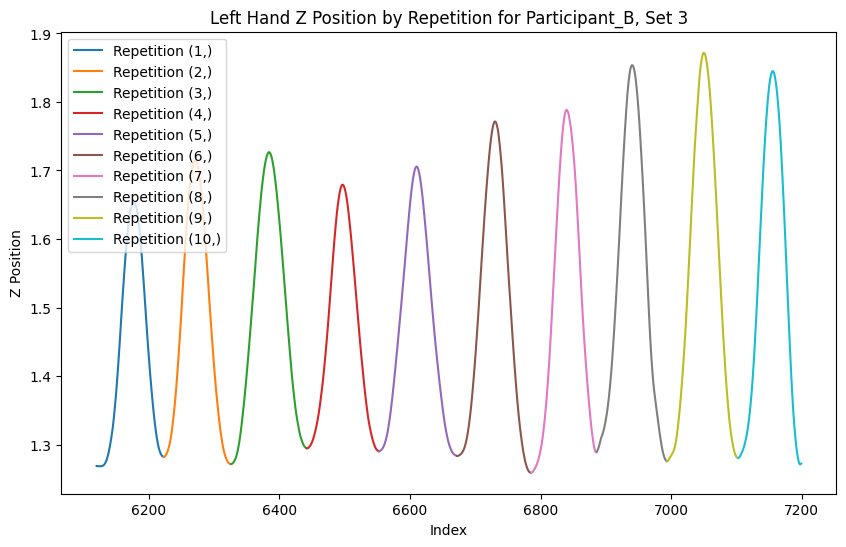

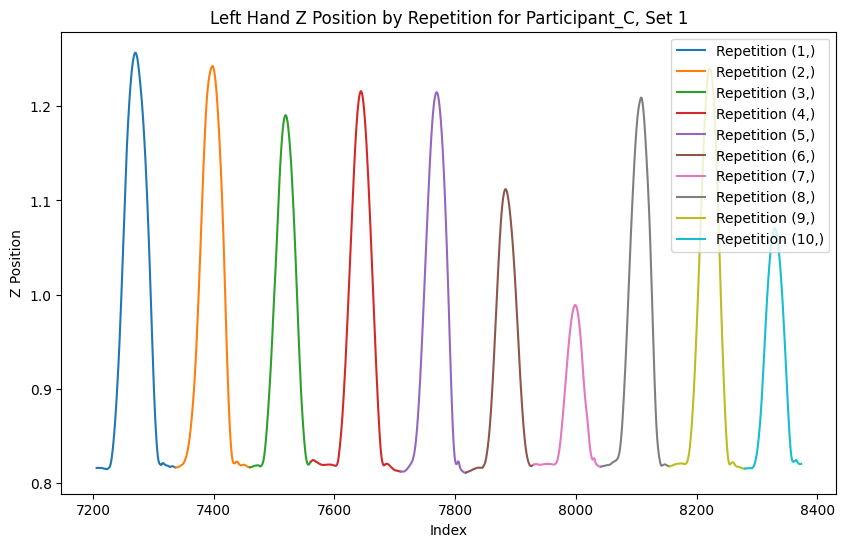

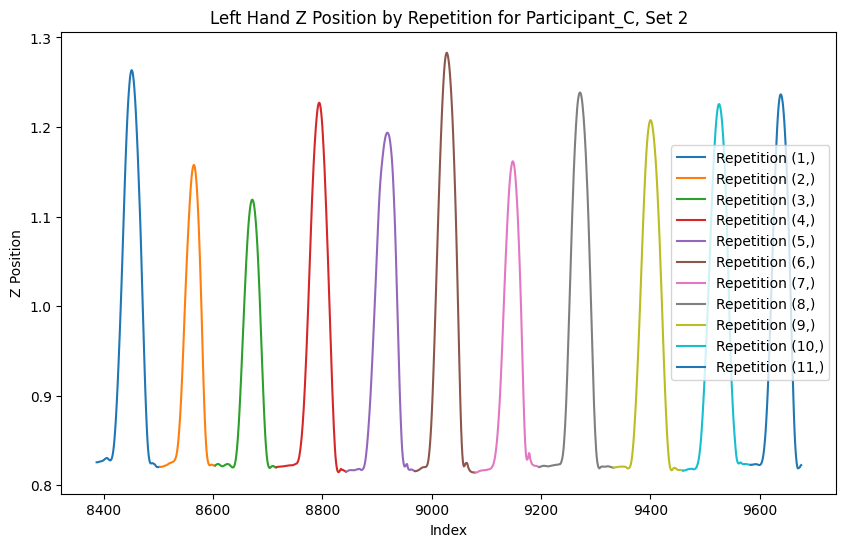

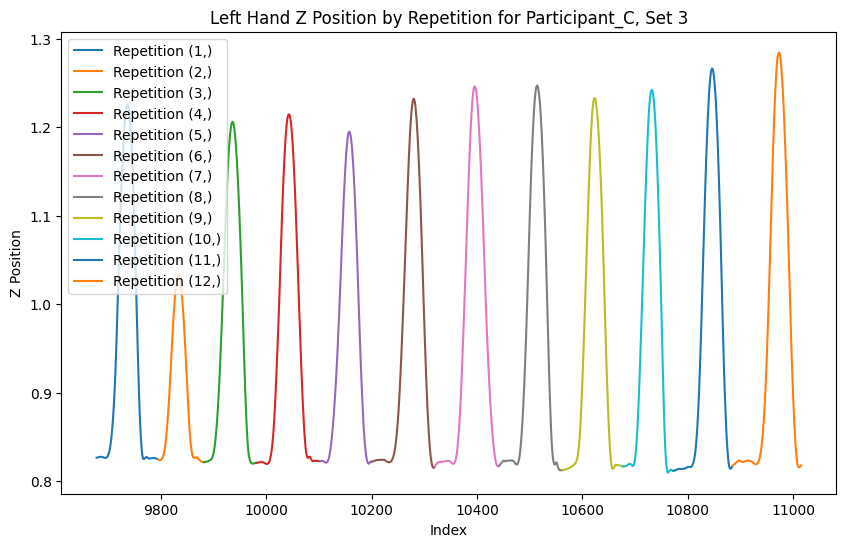

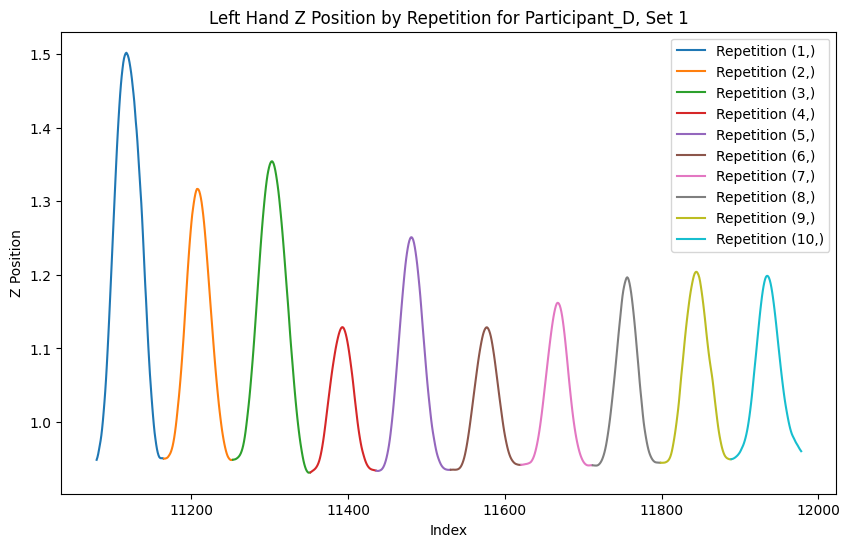

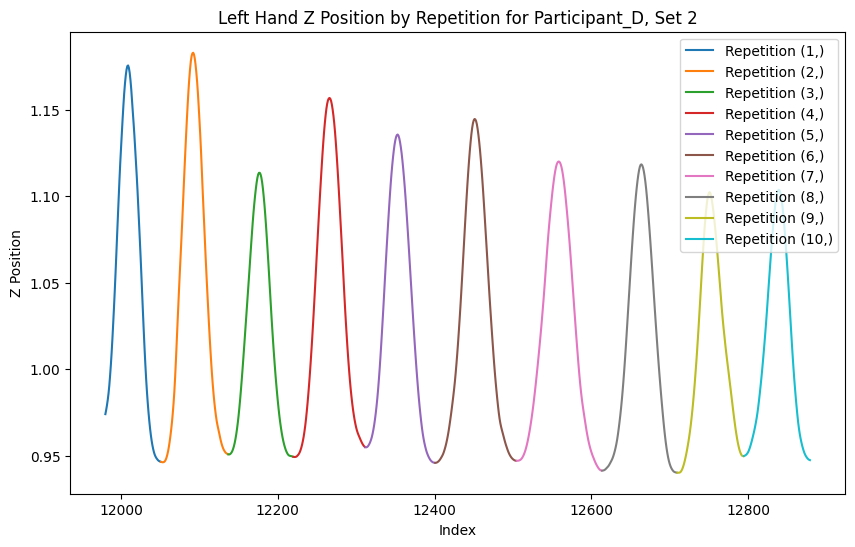

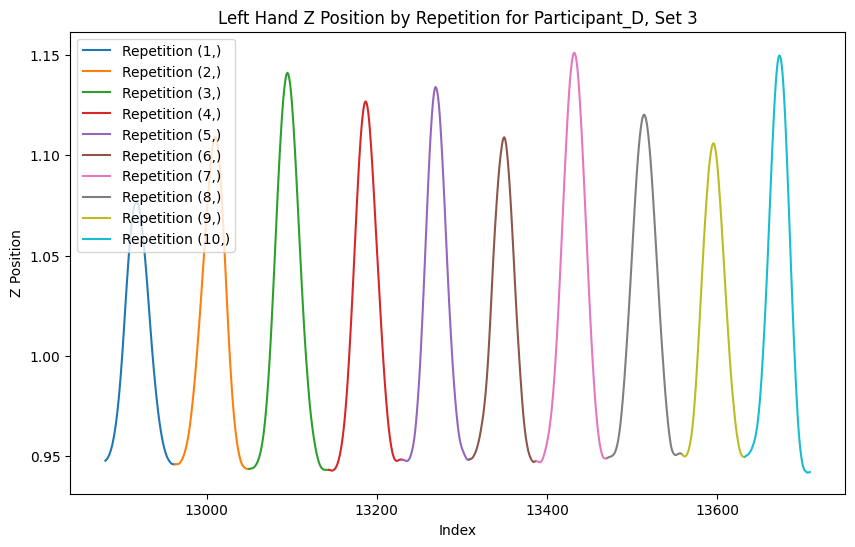

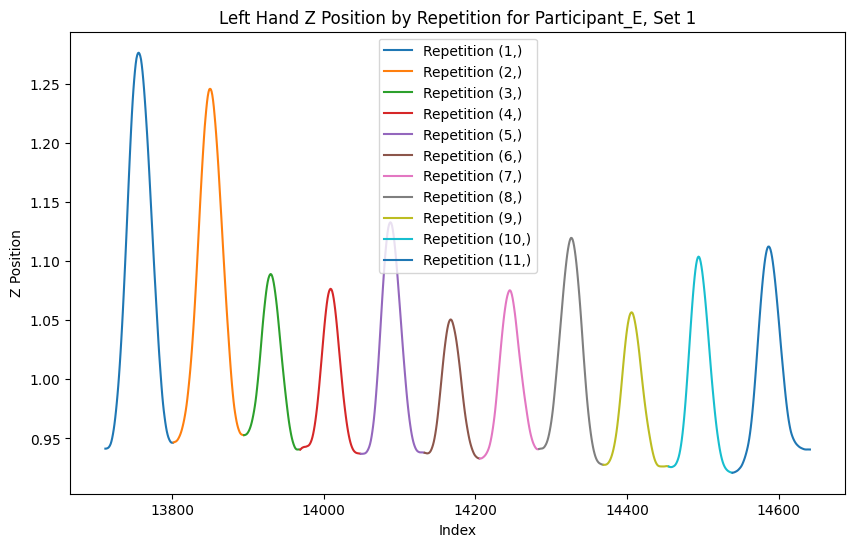

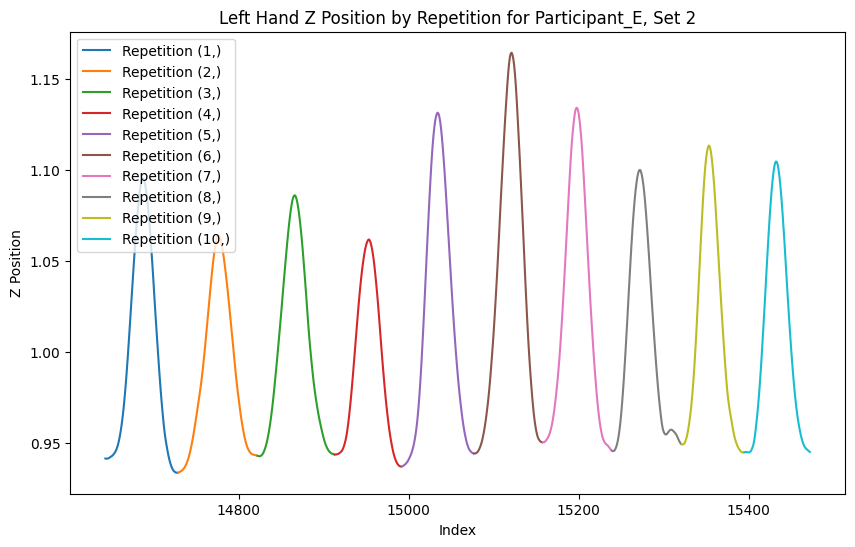

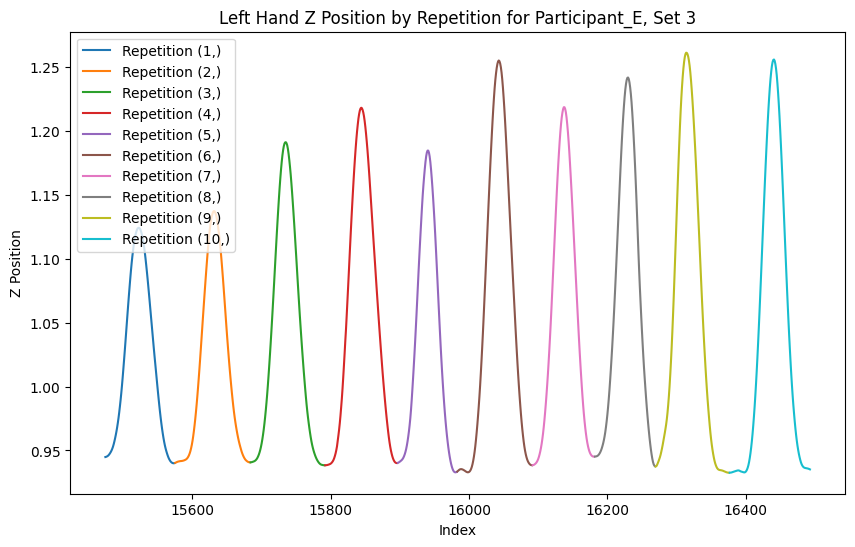

In [11]:
def plot_reps(df, column_name='Left Hand z position'):
    unique_participants = df['Participant'].unique()
    print(unique_participants)
    unique_sets = np.sort(df['Set'].unique())
    for participant in unique_participants:
        for set_num in unique_sets:
            d = df[(df["Participant"] == participant) & (df["Set"] == set_num)]
            if d.empty:
                continue

            unique_reps = d['Repetition'].unique()
            plt.figure(figsize=(10, 6))

            for rep in zip(unique_reps):
                rep_data = d[d['Repetition'] == rep]
                plt.plot(rep_data.index, rep_data[column_name], label=f'Repetition {rep}')

            plt.title(f'Left Hand Z Position by Repetition for {participant}, Set {set_num}')
            plt.xlabel('Index')
            plt.ylabel('Z Position')
            plt.legend()
            plt.show()

plot_reps(reps)
plot_reps(reps_incorrect)

# Preprocessing 

Low pass filter, resetting position to 0, scaling position data

## Step 1: Butterworth LPF

In [14]:
def butter_lowpass(cutoff, fs, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def lowpass_filter(data, cutoff, fs, order=4):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

In [15]:
selected_columns = [
    col for col in reps.columns
    if 'position' not in col.lower()
    and 'joint_angle' not in col.lower()
    and col not in ['Frame', 'Participant', 'Set', 'Repetition', 'Correct']
]

filtered_df = reps.copy()
for col in selected_columns:
    filtered_df[col] = lowpass_filter(reps[col], cutoff=3, fs=60)

filtered_dfi = reps_incorrect.copy()
for col in selected_columns:
    filtered_dfi[col] = lowpass_filter(reps_incorrect[col], cutoff=3, fs=60)
filtered_dfi.to_pickle("data/out/incorrect_filtered_df.pkl")

Let's do a quick check

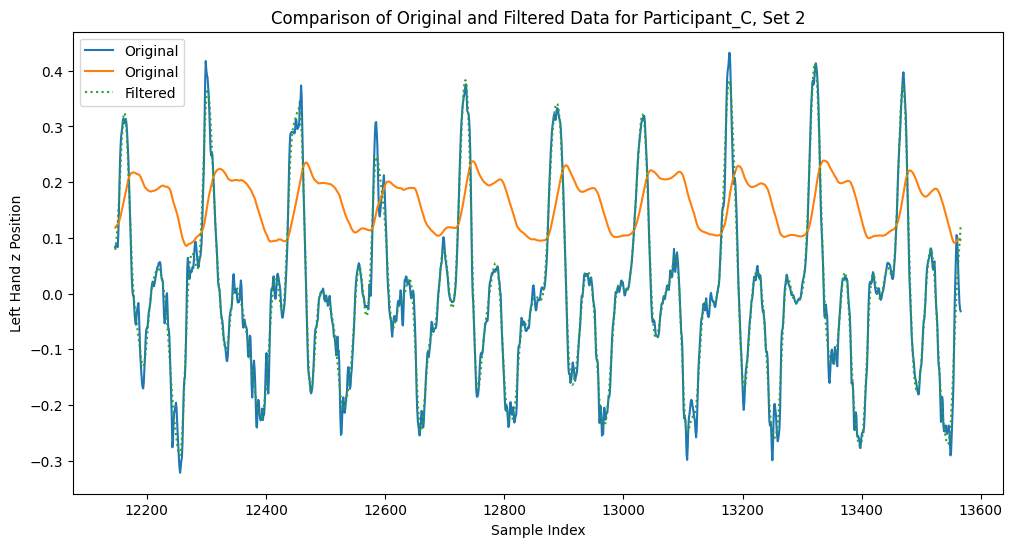

In [16]:
participant = 'Participant_C'
set_number = 2

l = reps[(reps['Participant'] == participant) & (reps['Set'] == set_number)]
o = filtered_df[(filtered_df['Participant'] == participant) & (filtered_df['Set'] == set_number)]

plt.figure(figsize=(12, 6))

plt.plot(l['Left Hand x vel'], label='Original')
plt.plot(l['Left Hand x position'], label='Original')
plt.plot(o['Left Hand x vel'], label='Filtered', linestyle='dotted')
plt.legend()
plt.title(f'Comparison of Original and Filtered Data for {participant}, Set {set_number}')
plt.xlabel('Sample Index')
plt.ylabel('Left Hand z Position')
plt.show()

## Step 2: Offset position data to start at 0 + scale using MinMax

In [ ]:
def offset_positions(df, position_columns):
    for participant in df['Participant'].unique():
        for set_ in df[df['Participant'] == participant]['Set'].unique():
            mask = (df['Participant'] == participant) & (df['Set'] == set_)
            for col in position_columns:
                initial_value = df.loc[mask, col].iloc[0]
                df.loc[mask, col] -= initial_value  # Offset
    return df

position_columns = [
    'Left Shoulder x position', 'Left Shoulder y position', 'Left Shoulder z position',
    'Left Upper Arm x position', 'Left Upper Arm y position', 'Left Upper Arm z position',
    'Left Forearm x position', 'Left Forearm y position', 'Left Forearm z position',
    'Left Hand x position', 'Left Hand y position', 'Left Hand z position'
]

In [18]:
dfc = filtered_df
dfi = filtered_dfi

scaler = MinMaxScaler()
combined_data = pd.concat([dfc[position_columns], dfi[position_columns]])
scaler.fit(combined_data)

# scale the position data 
dfc[position_columns] = scaler.transform(dfc[position_columns])
dfi[position_columns] = scaler.transform(dfi[position_columns])

# offset the position data
df_correct = offset_positions(dfc, position_columns)
df_incorrect = offset_positions(dfi, position_columns)

df_correct.to_pickle("data/out/correct_position_scaled_df.pkl")
df_incorrect.to_pickle("data/out/incorrect_position_scaled_df.pkl")

Let's do a quick visual check

In [ ]:
a = df_correct[df_correct["Participant"] == "Participant_A"]
b = df_correct[df_correct["Participant"] == "Participant_B"]
c = df_correct[df_correct["Participant"] == "Participant_C"]

# get position data for first 500 samples
xa, ya, za = a["Left Hand x position"][:500].values, a["Left Hand y position"][:500].values, a["Left Hand z position"][:500].values
xb, yb, zb = b["Left Hand x position"][:500].values, b["Left Hand y position"][:500].values, b["Left Hand z position"][:500].values
xc, yc, zc = c["Left Hand x position"][:500].values, c["Left Hand y position"][:500].values, c["Left Hand z position"][:500].values


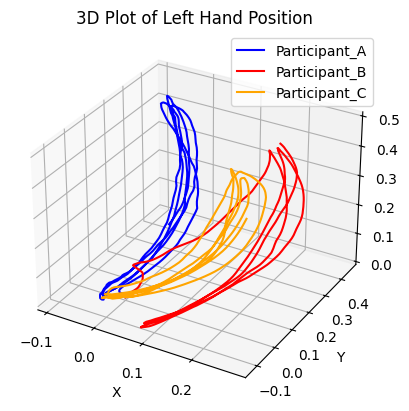

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(xa, ya, za, color='blue', label='Participant_A')
ax.plot(xb, yb, zb, color='red', label='Participant_B')
ax.plot(xc, yc, zc, color='orange', label='Participant_C')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Plot of Left Hand Position')
ax.legend()
plt.show()

# Others

Calculating average rep times for correct and incorrect exercises

In [ ]:
def calc_avg_rep(reps):
    reps['Duration'] = reps['Frame'] / 60.0
    reps['Duration'] = reps.groupby(['Participant', 'Set'])['Duration'].transform(lambda x: x - x.min())
    avg_durations = reps.groupby(['Participant'])['Duration'].mean().reset_index()
    print(avg_durations)

    return avg_durations

avg_durations_correct = calc_avg_rep(reps)
avg_durations_incorrect = calc_avg_rep(reps_incorrect)

avg_durations_correct['Type'] = 'Correct'
avg_durations_incorrect['Type'] = 'Incorrect'

avg_durations_combined = pd.concat([avg_durations_correct, avg_durations_incorrect])


C:\Users\Hp\AppData\Local\Temp\ipykernel_2676\63069412.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reps['Duration'] = reps['Frame'] / 60.0
C:\Users\Hp\AppData\Local\Temp\ipykernel_2676\63069412.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reps['Duration'] = reps.groupby(['Participant', 'Set'])['Duration'].transform(lambda x: x - x.min())
C:\Users\Hp\AppData\Local\Temp\ipykernel_2676\63069412.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

     Participant   Duration
0  Participant_A  13.996690
1  Participant_B  15.628910
2  Participant_C  11.802059
3  Participant_D  13.476483
4  Participant_E  13.388876
     Participant   Duration
0  Participant_A  10.804565
1  Participant_B   9.020068
2  Participant_C  10.569837
3  Participant_D   7.305097
4  Participant_E   7.768046


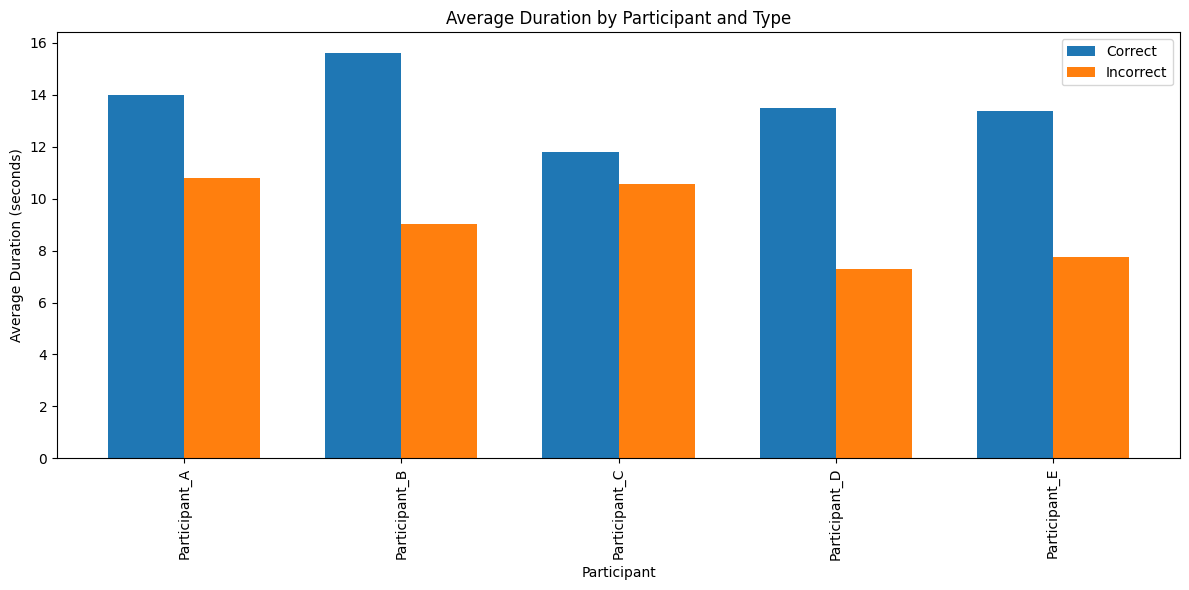

In [13]:
# grouped bar plot
def plot_grouped_avg_durations(df):
    participants = df['Participant'].unique()
    types = df['Type'].unique()
    bar_width = 0.35
    index = np.arange(len(participants))

    fig, ax = plt.subplots(figsize=(12, 6))

    for i, t in enumerate(types):
        type_data = df[df['Type'] == t]
        ax.bar(index + i * bar_width, type_data['Duration'], bar_width, label=t)

    ax.set_xlabel('Participant')
    ax.set_ylabel('Average Duration (seconds)')
    ax.set_title('Average Duration by Participant and Type')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(participants)
    ax.legend()

    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

# Plot the combined average durations
plot_grouped_avg_durations(avg_durations_combined)